In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load data
url = "https://raw.githubusercontent.com/SamirMoustafa/nmt-with-attention-for-ar-to-en/master/ara_.txt"
data = tf.keras.utils.get_file('ara_.txt', url)

# Read data
with open(data, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

# Print the first few lines of the data
for line in lines[:5]:
    print(line)

763396/763396 [==============================] - 0s 0us/step
Hi.	مرحبًا.
Run!	اركض!
Help!	النجدة!
Jump!	اقفز!
Stop!	قف!


In [3]:
# Prepare data
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

for line in lines:
    if '\t' not in line:
        continue
    input_text, target_text = line.split('\t')
    # Add start and end tokens to target sequences
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [4]:
# Tokenize input and target texts
input_tokenizer = Tokenizer(char_level=True)
input_tokenizer.fit_on_texts(input_texts)
target_tokenizer = Tokenizer(char_level=True)
target_tokenizer.fit_on_texts(target_texts)

# Convert texts to sequences
encoder_input_sequences = input_tokenizer.texts_to_sequences(input_texts)
decoder_input_sequences = target_tokenizer.texts_to_sequences(target_texts)

# Pad sequences
encoder_input_data = pad_sequences(encoder_input_sequences, maxlen=max_encoder_seq_length, padding='post')
decoder_input_data = pad_sequences(decoder_input_sequences, maxlen=max_decoder_seq_length, padding='post')

# Prepare decoder target data
decoder_target_sequences = [sequence[1:] for sequence in decoder_input_sequences]  # Remove start token
decoder_target_data = pad_sequences(decoder_target_sequences, maxlen=max_decoder_seq_length, padding='post')


# Split data into train and test sets
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2)

In [5]:
# Define model
embedding_size = 256
hidden_size = 512

encoder_inputs = tf.keras.layers.Input(shape=(None,))
encoder_embedding = tf.keras.layers.Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)
encoder_lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = tf.keras.layers.Input(shape=(None,))
decoder_embedding = tf.keras.layers.Embedding(num_decoder_tokens, embedding_size)
decoder_embedding_output = decoder_embedding(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

attention_layer = tf.keras.layers.Attention()
context_vector = attention_layer([decoder_outputs, encoder_outputs])

decoder_combined_context = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, context_vector])

decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [6]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
108/108 [==============================] - 28s 139ms/step - loss: 0.4846 - accuracy: 0.8975 - val_loss: 0.3219 - val_accuracy: 0.9154
Epoch 2/10
108/108 [==============================] - 13s 119ms/step - loss: 0.3076 - accuracy: 0.9196 - val_loss: 0.2846 - val_accuracy: 0.9240
Epoch 3/10
108/108 [==============================] - 13s 120ms/step - loss: 0.2839 - accuracy: 0.9240 - val_loss: 0.2690 - val_accuracy: 0.9273
Epoch 4/10
108/108 [==============================] - 13s 123ms/step - loss: 0.2697 - accuracy: 0.9272 - val_loss: 0.2567 - val_accuracy: 0.9307
Epoch 5/10
108/108 [==============================] - 14s 127ms/step - loss: 0.2581 - accuracy: 0.9298 - val_loss: 0.2473 - val_accuracy: 0.9325
Epoch 6/10
108/108 [==============================] - 14s 127ms/step - loss: 0.2485 - accuracy: 0.9317 - val_loss: 0.2377 - val_accuracy: 0.9346
Epoch 7/10
108/108 [==============================] - 14s 127ms/step - loss: 0.2391 - accuracy: 0.9343 - val_loss: 0.2288 - val_ac

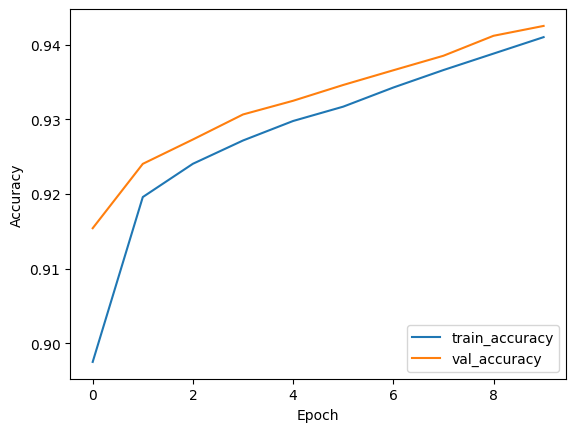

Final Train Loss: 0.2125
Final Train Accuracy: 0.9410
68/68 [==============================] - 2s 29ms/step - loss: 0.2138 - accuracy: 0.9411
Test Loss: 0.2137773185968399
Test Accuracy: 0.9411109685897827


In [7]:
# Train model
history = model.fit([encoder_input_train, decoder_input_train], decoder_target_train,
                    batch_size=64,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1)

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Print final training loss and accuracy
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_accuracy:.4f}")

# Evaluate model
test_loss, test_accuracy = model.evaluate([encoder_input_test, decoder_input_test], decoder_target_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)